In [58]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import rel_entr

### Load Data

In [59]:
loaded = np.load('./data/pure_coordination_5M.npz')
name = 'Pure Coordination'
rewards = loaded['rewards']
checkpoints = loaded['checkpoints']
row_rewards = rewards[:,:,0]
col_rewards = rewards[:,:,1]
row_rewards

array([[ 7.52145262,  7.79324194,  8.49824065, 10.50226903,  6.51527778,
         9.31321851,  7.05962371,  9.66053391,  7.29454215,  5.89336987,
         9.6725913 ,  9.24034703,  6.17433403, 10.56509139,  8.00558875,
         7.43022996,  8.41340049,  8.39040404,  8.72739245,  6.77845543,
         8.83330549,  6.19973657,  7.45925741,  6.95606909,  7.12394829,
         8.011131  ,  7.94148769,  8.89263784,  7.3615624 ,  7.89332011,
         9.10684229,  8.68683095,  8.15788684, 10.8325418 ,  8.90667388,
         9.16858974,  5.98762816, 10.06949902,  6.79826285,  6.47388675,
         8.07950801,  9.96495319,  8.64350554,  8.36328976,  7.39116162,
         9.2405424 ,  6.41522461,  6.36236631,  9.48350609,  8.64918711],
       [ 8.21032412,  8.91435509,  9.14492578,  8.45567766,  9.08800089,
        10.31763598,  7.78545445,  9.39855033,  8.99800936,  8.81499149,
         6.92976823, 10.33321308, 11.04892256,  7.78234127,  7.9954268 ,
         9.65215591, 10.43331257,  8.26653162,  9.

### KL Divergence

In [60]:
# start = np.min(row_rewards)
# end = np.max(row_rewards)
start = 0
end = 150
num_bins = 50
# marginal distribution
total_rewards = row_rewards.flatten()
marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
marginal_distribution = marginal_hist / sum(marginal_hist)
# KL divergence
KL_divergence = np.zeros(len(row_rewards))
for i in range(len(row_rewards)):
    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
    distribution = hist / sum(hist)
    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
# index
index = sum(KL_divergence)/len(KL_divergence)
print(index)

1.2434703247176915


### Turn to DataFrame

In [61]:
# convert to dataframe for plotting
checkpoint_str = ["checkpoint "+str(x) for x in checkpoints]
# reshape the 2D Numpy array to 1D array
flattened_ego_rewards = row_rewards.flatten()
flattened_opp_rewards = col_rewards.flatten()
# Create column names for the DataFrame
column_names = ['row reward', 'col reward', 'checkpoint']
# Create an array with repeated row numbers
checkpoint_names = np.repeat(checkpoint_str, len(row_rewards[0]))
# Create the DataFrame
df = pd.DataFrame({'row reward': flattened_ego_rewards, 'col reward': flattened_opp_rewards, 'checkpoint': checkpoint_names}, columns=column_names)
df

,row reward,col reward,checkpoint
0,7.521453,7.521453,checkpoint 20
1,7.793242,7.793242,checkpoint 20
2,8.498241,8.498241,checkpoint 20
3,10.502269,10.502269,checkpoint 20
4,6.515278,6.515278,checkpoint 20
...,...,...,...
545,25.884563,25.884563,checkpoint 2740
546,24.846190,24.846190,checkpoint 2740
547,24.760053,24.760053,checkpoint 2740
548,28.260455,28.260455,checkpoint 2740


### Ridge Plot

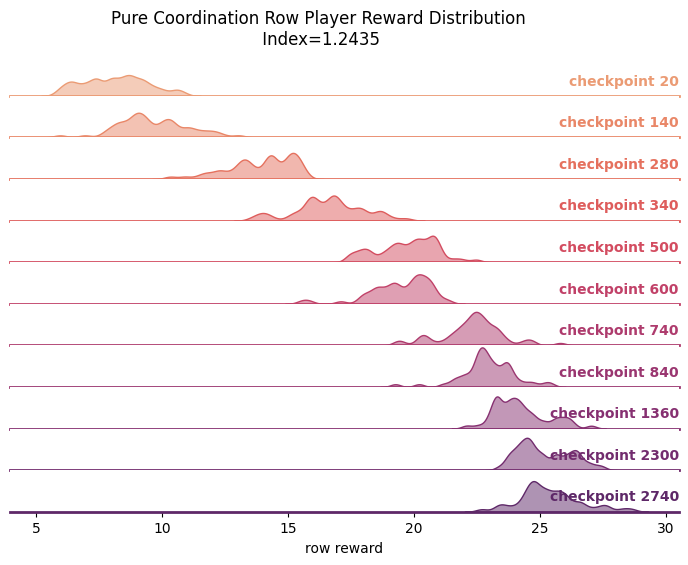

In [62]:
g = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='flare')
# h = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='crest')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="row reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map_dataframe(sns.kdeplot, x="opp_reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "row reward")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Row Player Reward Distribution\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' row reward distribution.pdf'), bbox_inches='tight')

### Comparison DataFrame

In [63]:
new_df = pd.DataFrame({'reward': df['col reward'].tolist()+df['row reward'].tolist(),
                       'label': ['col']*len(df['col reward'])+['row']*len(df['row reward']),
                       'checkpoint': df['checkpoint'].tolist()*2},
                      columns=['reward','label','checkpoint'])
new_df

,reward,label,checkpoint
0,7.521453,col,checkpoint 20
1,7.793242,col,checkpoint 20
2,8.498241,col,checkpoint 20
3,10.502269,col,checkpoint 20
4,6.515278,col,checkpoint 20
...,...,...,...
1095,25.884563,row,checkpoint 2740
1096,24.846190,row,checkpoint 2740
1097,24.760053,row,checkpoint 2740
1098,28.260455,row,checkpoint 2740


### Comparison Ridge Plot

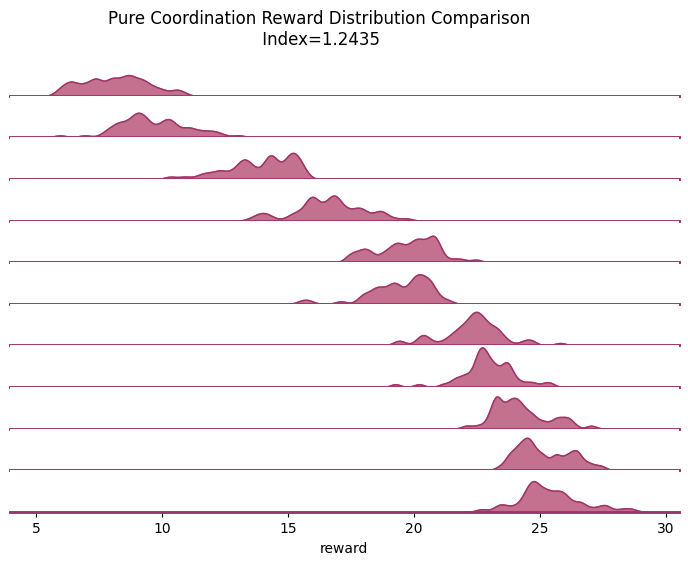

In [64]:
g = sns.FacetGrid(new_df, row="checkpoint", hue="label", aspect=15, height=.5, palette='flare')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.3)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # ax.text(1, .2, label, fontweight="bold", color=color,
    #         ha="right", va="bottom", transform=ax.transAxes)
# def annotate(data, color, **kws):
#     n = data['checkpoint']
#     ax = plt.gca()
#     ax.text(1, 0.2, f'{n}', fontweight="bold", color=color, ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "reward")
# g.map_dataframe(annotate)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Reward Distribution Comparison\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' distribution comparison.pdf'), bbox_inches='tight')